#Import Libraries for Data Processing

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler

#Read In Data

In [ ]:
train_data = pd.read_csv('train.csv')
oil_data = pd.read_csv("oil.csv")
store_data = pd.read_csv("stores.csv")
transactions_data = pd.read_csv("transactions.csv")
holiday_events_data = pd.read_csv("holidays_events.csv")

#Build Training Data and Collect Features

In [ ]:
#PRE-PROCESSING TRAINING DATA

grouped_sales = train_data.pivot_table(index=['date', 'store_nbr'], columns='family', values='sales', aggfunc='sum')

grouped_sales.columns = [f'{column}_SALES' for column in grouped_sales.columns]

grouped_onpromotion = train_data.pivot_table(index=['date', 'store_nbr'], columns='family', values='onpromotion', aggfunc='sum')

grouped_onpromotion.columns = [f'{column}_ONPROMOTION' for column in grouped_onpromotion.columns]

cleaned_train_data = pd.concat([grouped_sales, grouped_onpromotion], axis=1).reset_index()

cleaned_train_data['date'] = pd.to_datetime(cleaned_train_data['date'])

#PRE-PROCESSING OIL DATA

oil_data['date'] = pd.to_datetime(oil_data['date'])

oil_data.set_index('date', inplace=True)

date_range = pd.date_range(start='2013-01-01', end='2017-08-31', freq='D')

oil_data = oil_data.reindex(date_range)

mean_oil_price_na = oil_data['dcoilwtico'].rolling(window=15, center=True, min_periods=1).mean()

oil_data['dcoilwtico'].fillna(mean_oil_price_na, inplace=True)

oil_data.reset_index(inplace=True)
oil_data.rename(columns={'index': 'date'}, inplace=True)

#MERGING OIL DATA COLUMNS

cleaned_train_data = pd.merge(cleaned_train_data, oil_data, on='date', how='left')

#MERGING STORE DATA COLUMNS

#Using left join to retain all the values from cleaned_train_data and just add the values from store_data to it
cleaned_train_data = pd.merge(cleaned_train_data, store_data, on='store_nbr', how='left')

#PRE-PROCESSING HOLIDAY EVENTS DATA

holiday_events_data['date'] = pd.to_datetime(holiday_events_data['date'])

#HOLIDAY EVENTS DATA PROCESSING

#Using the dates given in holiday events dataset and ignoring the number to then mark which days in the training dataset have holidays on them.

holiday_events_data['date'] = pd.to_datetime(holiday_events_data['date'])

holiday_events_data['month_day'] = holiday_events_data['date'].dt.strftime('%m-%d')
cleaned_train_data['month_day'] = cleaned_train_data['date'].dt.strftime('%m-%d')

holiday_month_days = set(holiday_events_data['month_day'])

cleaned_train_data['has_holiday'] = cleaned_train_data['month_day'].apply(lambda x: 1 if x in holiday_month_days else 0)

cleaned_train_data.drop('month_day', axis=1, inplace=True)

#Also using holiday dates to count the days until the next day in order to capture the correlation between the ramp up in sales to the occurence of the holiday. The holiday metric above isn't cutting it. Going to use a falg of three days, 1 week, and 2 weeks.

holiday_dates = cleaned_train_data[cleaned_train_data['has_holiday'] == 1]['date'].unique()

cleaned_train_data['three_days_before_holiday'] = 0
cleaned_train_data['one_week_before_holiday'] = 0
cleaned_train_data['two_weeks_before_holiday'] = 0
cleaned_train_data['three_weeks_before_holiday'] = 0

for holiday in holiday_dates:
    three_days_before = holiday - pd.Timedelta(days=3)
    one_week_before = holiday - pd.Timedelta(days=7)
    two_weeks_before = holiday - pd.Timedelta(days=14)
    three_weeks_before = holiday - pd.Timedelta(days=21)

    mask_three_days = (cleaned_train_data['date'] >= three_days_before) & (cleaned_train_data['date'] < holiday)
    cleaned_train_data.loc[mask_three_days, 'three_days_before_holiday'] = 1

    mask_one_week = (cleaned_train_data['date'] >= one_week_before) & (cleaned_train_data['date'] < holiday)
    cleaned_train_data.loc[mask_one_week, 'one_week_before_holiday'] = 1

    mask_two_weeks = (cleaned_train_data['date'] >= two_weeks_before) & (cleaned_train_data['date'] < one_week_before)
    cleaned_train_data.loc[mask_two_weeks, 'two_weeks_before_holiday'] = 1

    mask_three_weeks = (cleaned_train_data['date'] >= three_weeks_before) & (cleaned_train_data['date'] < two_weeks_before)
    cleaned_train_data.loc[mask_three_weeks, 'three_weeks_before_holiday'] = 1

cleaned_train_data.loc[cleaned_train_data['has_holiday'] == 1, ['three_days_before_holiday', 'one_week_before_holiday', 'two_weeks_before_holiday', 'three_weeks_before_holiday']] = 0

#CONVERTING DATE INTO SEPERATE FEATURES
cleaned_train_data['dow'] = cleaned_train_data['date'].dt.dayofweek
cleaned_train_data['month'] = cleaned_train_data['date'].dt.month
cleaned_train_data['num_date'] = cleaned_train_data['date'].dt.day
cleaned_train_data['year'] = cleaned_train_data['date'].dt.year

#USING LABEL ENCODING TO CONVERT STORE LOCATIONS AND HOLIDAY LOCATIONS INTO NUMERICAL REPRESENTATIONS
label_encoder = LabelEncoder()
label_encoder.fit(pd.concat([cleaned_train_data['city'], cleaned_train_data['state']]))

cleaned_train_data['city'] = label_encoder.transform(cleaned_train_data['city'])
cleaned_train_data['state'] = label_encoder.transform(cleaned_train_data['state'])

#USING LABEL ENCODING TO CONVERT STORE TYPE TO A NUMERICAL REPRESENTATION
cleaned_train_data['type'] = LabelEncoder().fit_transform(cleaned_train_data['type'])

#One-Hot Encoding Store Nbr to avoid possible relationships from forming when training model
cleaned_train_data = pd.get_dummies(cleaned_train_data, columns=['store_nbr'])

#Split Data and Scale X & Y Data to prepare for training

In [ ]:
print("# OF TIMESTEPS IN DATA: ", (len(cleaned_train_data)/54))

y_columns = [column for column in cleaned_train_data.columns if column.endswith("_SALES")]

y = cleaned_train_data[y_columns]

X = cleaned_train_data.drop(y_columns + ['date'], axis=1)

x_data_scaler = MinMaxScaler()
y_data_scaler = MinMaxScaler()

scaled_X_train = x_data_scaler.fit_transform(X)

scaled_Y_train = y_data_scaler.fit_transform(y)

print("SHAPE OF X before timestep reshaping:", scaled_X_train.shape)
print("SHAPE OF y before timestep reshaping:", scaled_Y_train.shape)

scaled_X_train = scaled_X_train.reshape(((int(len(cleaned_train_data)/54)), 54, scaled_X_train.shape[1]))
scaled_Y_train = scaled_Y_train.reshape(((int(len(cleaned_train_data)/54)), 54, scaled_Y_train.shape[1]))

print("SHAPE OF scaled_X_train after timestep reshaping:", scaled_X_train.shape)
print("SHAPE OF scaled_Y_train after timestep reshaping:", scaled_Y_train.shape)

# OF TIMESTEPS IN DATA:  1684.0
SHAPE OF X before timestep reshaping: (90936, 101)
SHAPE OF y before timestep reshaping: (90936, 33)
SHAPE OF scaled_X_train after timestep reshaping: (1684, 54, 101)
SHAPE OF scaled_Y_train after timestep reshaping: (1684, 54, 33)


#Import Libraries Needed for Building Hybrid CNN and LSTM

In [ ]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv1D, LSTM, TimeDistributed, BatchNormalization, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Nadam, Adam, RMSprop, Adagrad
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os
import math

#Build Hybrid Model Containing CNN Layers, Normalizing Layers, and a LSTM layer

In [ ]:
cnn_lstm_model = Sequential(layers=[
      Conv1D(64, 3, activation="relu", padding="same", input_shape=(54, scaled_X_train.shape[2])),
      BatchNormalization(),
      Dropout(0.2),

      Conv1D(128, 9, activation="relu", padding="same"),
      BatchNormalization(),
      Dropout(0.2),

      LSTM(50, activation='tanh', return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
      TimeDistributed(Dense(33)),
  ])

cnn_lstm_model.compile(optimizer=Nadam(learning_rate=0.001), loss='mse')

#Split Training Data into training and validation

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(scaled_X_train, scaled_Y_train, test_size=0.2)

#Fit Model with Training and Validation Data

In [ ]:
import matplotlib.pyplot as plotter
import time

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

start = time.time()

if os.path.exists('cnn_lstm_model-BEST.keras'):
    cnn_lstm_model = load_model('cnn_lstm_model-BEST.keras')
else:
  model_history = cnn_lstm_model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stop])
  print("%ss" % (time.time() - start))

  plotter.plot(model_history.history['loss'])
  plotter.plot(model_history.history['val_loss'])
  plotter.title("Hybrid CNN LSTM Model Loss")
  plotter.xlabel("Epoch")
  plotter.ylabel("Loss")
  plotter.legend(['Train', 'Validation'])
  plotter.show()

#Read in Test Data

In [ ]:
test_data = pd.read_csv('test.csv')

#Prepare Test Data for Model

In [ ]:
#PRE-PROCESSING TRAINING DATA

grouped_test_onpromotion = test_data.pivot_table(index=['date', 'store_nbr'], columns='family', values='onpromotion', aggfunc='sum')

grouped_test_onpromotion.columns = [f'{column}_ONPROMOTION' for column in grouped_test_onpromotion.columns]

cleaned_test_data = pd.concat([grouped_test_onpromotion], axis=1).reset_index()

cleaned_test_data['date'] = pd.to_datetime(cleaned_test_data['date'])

#MERGING OIL DATA COLUMNS

cleaned_test_data = pd.merge(cleaned_test_data, oil_data, on='date', how='left')

#MERGING STORE DATA COLUMNS

#using left join to retain all the values from cleaned_test_data and just add the values from store_data to it
cleaned_test_data = pd.merge(cleaned_test_data, store_data, on='store_nbr', how='left')

#MERGING TRANSACTION DATA COLUMN

#MERGING HOLIDAY EVENTS DATA

holiday_events_data['month_day'] = holiday_events_data['date'].dt.strftime('%m-%d')
cleaned_test_data['month_day'] = cleaned_test_data['date'].dt.strftime('%m-%d')

holiday_month_days = set(holiday_events_data['month_day'])

cleaned_test_data['has_holiday'] = cleaned_test_data['month_day'].apply(lambda x: 1 if x in holiday_month_days else 0)

cleaned_test_data.drop('month_day', axis=1, inplace=True)

#Also using holiday dates to count the days until the next day in order to capture the correlation between the ramp up in sales to the occurence of the holiday. The holiday metric above isn't cutting it. Going to use a falg of three days, 1 week, and 2 weeks.

holiday_dates = cleaned_test_data[cleaned_test_data['has_holiday'] == 1]['date'].unique()

cleaned_test_data['three_days_before_holiday'] = 0
cleaned_test_data['one_week_before_holiday'] = 0
cleaned_test_data['two_weeks_before_holiday'] = 0
cleaned_test_data['three_weeks_before_holiday'] = 0

for holiday in holiday_dates:
    three_days_before = holiday - pd.Timedelta(days=3)
    one_week_before = holiday - pd.Timedelta(days=7)
    two_weeks_before = holiday - pd.Timedelta(days=14)
    three_weeks_before = holiday - pd.Timedelta(days=21)

    mask_three_days = (cleaned_test_data['date'] >= three_days_before) & (cleaned_test_data['date'] < holiday)
    cleaned_test_data.loc[mask_three_days, 'three_days_before_holiday'] = 1

    mask_one_week = (cleaned_test_data['date'] >= one_week_before) & (cleaned_test_data['date'] < holiday)
    cleaned_test_data.loc[mask_one_week, 'one_week_before_holiday'] = 1

    mask_two_weeks = (cleaned_test_data['date'] >= two_weeks_before) & (cleaned_test_data['date'] < one_week_before)
    cleaned_test_data.loc[mask_two_weeks, 'two_weeks_before_holiday'] = 1

    mask_three_weeks = (cleaned_test_data['date'] >= three_weeks_before) & (cleaned_test_data['date'] < two_weeks_before)
    cleaned_test_data.loc[mask_three_weeks, 'three_weeks_before_holiday'] = 1

cleaned_test_data.loc[cleaned_test_data['has_holiday'] == 1, ['three_days_before_holiday', 'one_week_before_holiday', 'two_weeks_before_holiday', 'three_weeks_before_holiday']] = 0

#CONVERTING DATE INTO SEPERATE FEATURES
cleaned_test_data['dow'] = cleaned_test_data['date'].dt.dayofweek
cleaned_test_data['month'] = cleaned_test_data['date'].dt.month
cleaned_test_data['num_date'] = cleaned_test_data['date'].dt.day
cleaned_test_data['year'] = cleaned_test_data['date'].dt.year

#USING LABEL ENCODING TO CONVERT STORE LOCATIONS AND HOLIDAY LOCATIONS INTO NUMERICAL REPRESENTATIONS
label_encoder = LabelEncoder()
label_encoder.fit(pd.concat([cleaned_test_data['city'], cleaned_test_data['state']]))

cleaned_test_data['city'] = label_encoder.transform(cleaned_test_data['city'])
cleaned_test_data['state'] = label_encoder.transform(cleaned_test_data['state'])

#USING LABEL ENCODING TO CONVERT STORE TYPE TO A NUMERICAL REPRESENTATION
cleaned_test_data['type'] = LabelEncoder().fit_transform(cleaned_test_data['type'])

#One-Hot Encoding Store Nbr to avoid possible relationships from forming when trianing model
cleaned_test_data = pd.get_dummies(cleaned_test_data, columns=['store_nbr'])

cleaned_test_data.head()

,date,AUTOMOTIVE_ONPROMOTION,BABY CARE_ONPROMOTION,BEAUTY_ONPROMOTION,BEVERAGES_ONPROMOTION,BOOKS_ONPROMOTION,BREAD/BAKERY_ONPROMOTION,CELEBRATION_ONPROMOTION,CLEANING_ONPROMOTION,DAIRY_ONPROMOTION,...,store_nbr_45,store_nbr_46,store_nbr_47,store_nbr_48,store_nbr_49,store_nbr_50,store_nbr_51,store_nbr_52,store_nbr_53,store_nbr_54
0,2017-08-16,0,0,2,20,0,12,0,25,45,...,False,False,False,False,False,False,False,False,False,False
1,2017-08-16,0,0,2,23,0,12,0,22,41,...,False,False,False,False,False,False,False,False,False,False
2,2017-08-16,0,0,2,21,0,12,0,22,37,...,False,False,False,False,False,False,False,False,False,False
3,2017-08-16,0,0,2,21,0,12,0,23,43,...,False,False,False,False,False,False,False,False,False,False
4,2017-08-16,0,0,2,20,0,12,0,24,42,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
print(len(cleaned_test_data))

864


#Scale Cleaned Test Data

In [ ]:
X_test = np.log1p(cleaned_test_data.drop('date', axis=1))

scaled_X_test = x_data_scaler.transform(X_test)

print("SHAPE OF SCALED_X_TEST BEFORE RESHAPING:", scaled_X_test.shape)

scaled_X_test = scaled_X_test.reshape(((int(len(scaled_X_test)/54)), 54, scaled_X_test.shape[1]))

print("SHAPE OF SCALED_X_TEST AFTER RESHAPING:", scaled_X_test.shape)

SHAPE OF SCALED_X_TEST BEFORE RESHAPING: (864, 101)
SHAPE OF SCALED_X_TEST AFTER RESHAPING: (16, 54, 101)


#Predict Values for Train Set

In [ ]:
predicted_vals = cnn_lstm_model.predict(scaled_X_train)

predicted_train_vals_rescaled = y_data_scaler.inverse_transform(predicted_vals.reshape(-1, predicted_vals.shape[-1]))

predicted_train_vals_rescaled[predicted_train_vals_rescaled < 0] = 0

y_train_rescaled = y_data_scaler.inverse_transform(scaled_Y_train.reshape(-1, scaled_Y_train.shape[-1]))


53/53 [==============================] - 1s 20ms/step


#Calculating MAE of Model Predictions on Training Data

MAE on Rescaled Training Data: 58.26003076830592
RMSE on Rescaled Training Data: 257.2592836772915


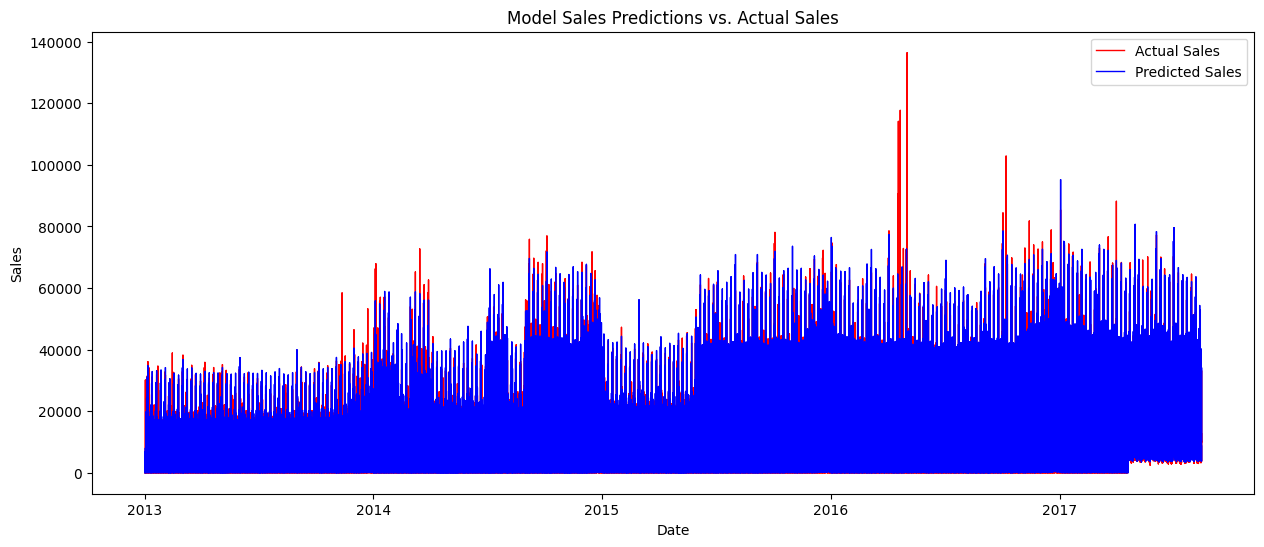

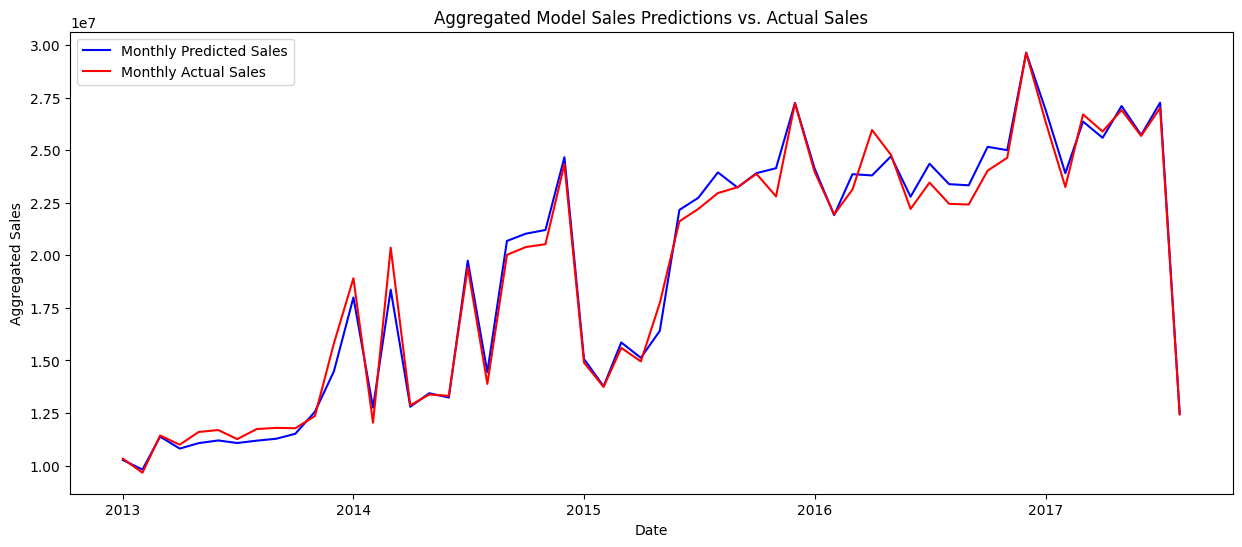

In [ ]:
mae = mean_absolute_error(predicted_train_vals_rescaled, y_train_rescaled)
print(f"MAE on Rescaled Training Data: {mae}")

rmse = math.sqrt(mean_squared_error(predicted_train_vals_rescaled, y_train_rescaled))
print(f"RMSE on Rescaled Training Data: {rmse}")

total_predicted_sales = np.sum(predicted_train_vals_rescaled, axis=1)

total_actual_sales = np.sum(y_train_rescaled, axis=1)

pred_df_copy = cleaned_train_data.drop(columns=cleaned_train_data.columns.difference(['date']))

pred_df_copy['predicted_sales'] = total_predicted_sales

actual_df_copy = cleaned_train_data.drop(columns=cleaned_train_data.columns.difference(['date']))

actual_df_copy['actual_sales'] = total_actual_sales


plotter.figure(figsize=(15, 6))
plotter.plot(actual_df_copy['date'], actual_df_copy['actual_sales'], label='Actual Sales', color='red', linewidth=1)
plotter.plot(pred_df_copy['date'], pred_df_copy['predicted_sales'], label='Predicted Sales', color='blue', linewidth=1)
plotter.title("Model Sales Predictions vs. Actual Sales")
plotter.xlabel("Date")
plotter.ylabel("Sales")
plotter.legend()
plotter.show()

pred_df_copy['month'] = pred_df_copy['date'].dt.to_period('M')
monthly_pred = pred_df_copy.groupby('month')['predicted_sales'].sum()
actual_df_copy['month'] = actual_df_copy['date'].dt.to_period('M')
monthly_actual = actual_df_copy.groupby('month')['actual_sales'].sum()

plotter.figure(figsize=(15, 6))
plotter.plot(monthly_pred.index.to_timestamp(), monthly_pred, 'b-', label='Monthly Predicted Sales')
plotter.plot(monthly_actual.index.to_timestamp(), monthly_actual, 'r-', label='Monthly Actual Sales')
plotter.title("Aggregated Model Sales Predictions vs. Actual Sales")
plotter.xlabel("Date")
plotter.ylabel("Aggregated Sales")
plotter.legend()
plotter.show()

In [ ]:
overestimated = 0
underestimated = 0

for i, pred in enumerate(monthly_pred):
    if monthly_actual[i] - monthly_pred[i] >= 0:
        underestimated += 1
    else:
        overestimated += 1

print(f"Overestimated: {overestimated}")
print(f"Underestimated: {underestimated}")

Overestimated: 20
Underestimated: 36


#Predict Values for Test Set

In [ ]:
predicted_vals = cnn_lstm_model.predict(scaled_X_test)

predicted_test_vals_rescaled = y_data_scaler.inverse_transform(predicted_vals.reshape(-1, predicted_vals.shape[-1]))

1/1 [==============================] - 0s 69ms/step


#Assemble Predictions into Submission CSV

In [ ]:
submission_dataframe = pd.DataFrame()

submission_dataframe['id'] = test_data['id']

submission_dataframe['sales'] = predicted_test_vals_rescaled.flatten()

submission_dataframe.to_csv('submission.csv', index=False)